In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from matplotlib.animation import FuncAnimation
from scipy.io import savemat

In [71]:
X = np.random.randint(2, size=(3000, 15))

y = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    y[i] = (X[:,0][i] or X[:,1][i]) and (X[:,2][i] or X[:,3][i])
      # y[i] = X[:,0][i] ^ X[:,1][i] ^ X[:,2][i]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.reshape((len(y_train), 1))
y_test = y_test.reshape((len(y_test), 1))

In [72]:
# Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Derivative of the sigmoid function
def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

# ReLU activation function
def relu(z):
    return np.maximum(0, z)

# Derivative of the ReLU function
def relu_derivative(z):
    return np.where(z > 0, 1, 0)

# Binary cross-entropy loss
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Initialize parameters
def initialize_parameters(input_dim, hidden_dim, output_dim):
    np.random.seed(42)
    W1 = np.random.randn(input_dim, hidden_dim) * 0.01
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) * 0.01
    b2 = np.zeros((1, output_dim))
    return W1, b1, W2, b2

# Forward propagation
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    cache = (Z1, A1, Z2, A2)
    return A2, cache

# Backward propagation
def backward_propagation(X, y, cache, W1, b1, W2, b2, learning_rate):
    Z1, A1, Z2, A2 = cache
    m = X.shape[0]

    dZ2 = A2 - y
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    return W1, b1, W2, b2

#Train
def train(X_train, X_test, y_train, y_test, hidden_dim, epochs, learning_rate):

    input_dim = X_train.shape[1]
    output_dim = 1
    W1, b1, W2, b2 = initialize_parameters(input_dim, hidden_dim, output_dim)
    
    train_loss = np.zeros((epochs,))
    test_loss = np.zeros((epochs,))
    train_accuracy = np.zeros((epochs,))
    test_accuracy = np.zeros((epochs,))

    W1_tensor = np.zeros((input_dim, hidden_dim, epochs))
    b1_tensor = np.zeros((hidden_dim, epochs))

    W2_tensor = np.zeros((hidden_dim, output_dim, epochs))
    b2_tensor = np.zeros((output_dim, epochs))

    for epoch in range(epochs):
        A2, cache = forward_propagation(X_train, W1, b1, W2, b2)
        W1, b1, W2, b2 = backward_propagation(X_train, y_train, cache, W1, b1, W2, b2, learning_rate)
        
        train_loss[epoch] = binary_cross_entropy(y_train, A2)

        A2_test, cache_test = forward_propagation(X_test, W1, b1, W2, b2)
        test_loss[epoch] = binary_cross_entropy(y_test, A2_test)

        train_accuracy[epoch] = accuracy(W1, b1, W2, b2, X_train, y_train)
        test_accuracy[epoch] = accuracy(W1, b1, W2, b2, X_test, y_test)
        
        W1_tensor[:,:,epoch] = W1
        b1_tensor[:,epoch] = b1

        W2_tensor[:,:,epoch] = W2
        b2_tensor[:,epoch] = b2
    return W1_tensor, b1_tensor, W2_tensor, b2_tensor, train_loss, test_loss, train_accuracy, test_accuracy

def accuracy(W1, b1, W2, b2, X, y):
    
    count = 0
    A2, cache = forward_propagation(X, W1, b1, W2, b2)

    pred = np.round(A2)
    
    for i in range(X.shape[0]):
        if(pred[i] == y[i]):
          count = count + 1
    
    return (count/X.shape[0])*100

In [97]:
W1, b1, W2, b2, train_loss, test_loss, train_accuracy, test_accuracy = train(X_train, X_test, y_train, y_test,10, 5000, 1)

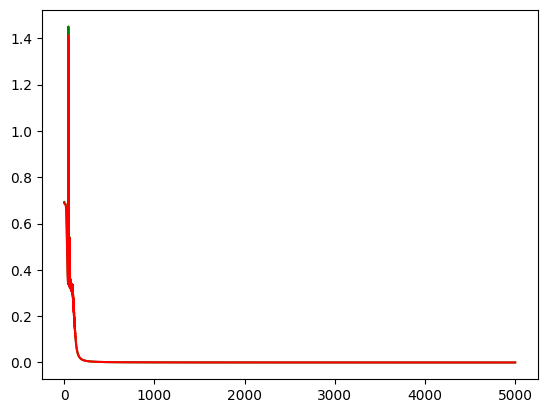

In [98]:
plt.plot(np.arange(len(train_loss)), train_loss, color = 'green')
plt.plot(np.arange(len(test_loss)), test_loss, color = 'red')

Text(0.5, 1.0, 'Blue: Train accuracy\nRed: Test accuracy')

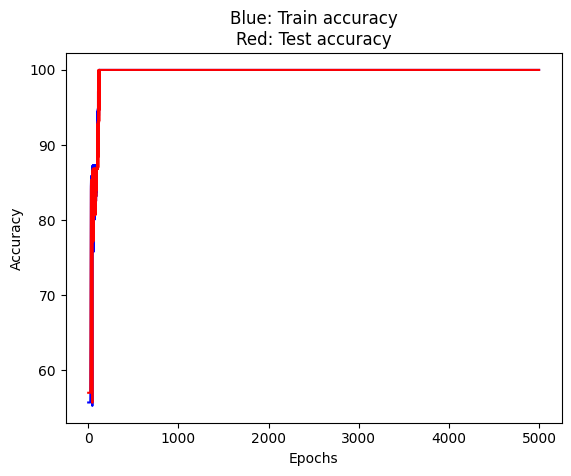

In [99]:
plt.plot(np.arange(len(train_accuracy)), train_accuracy, color = 'blue')
plt.plot(np.arange(len(test_accuracy)), test_accuracy, color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Blue: Train accuracy\nRed: Test accuracy')

Text(0.5, 1.0, 'Heatmap of W1')

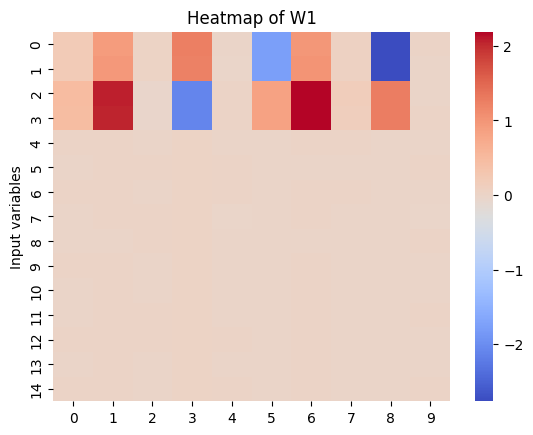

In [100]:
sns.heatmap(W1[:,:,len(train_accuracy)-1], cmap='coolwarm', fmt=".2f", cbar=True)

# Add labels and title
plt.ylabel('Input variables')
plt.title('Heatmap of W1')

In [101]:
savemat('W1.mat', {'W1': W1})